In [703]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [704]:
## Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # Avoid division by zero
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

In [705]:
df = pd.read_excel("AIB_History_Training_2014-2020.xlsx", sheet_name='HistoricalTransactions')
df = df.drop(columns=["FileFolder", "FileName", "Report_Title", "Report_RunDate", "Report_AsOfDate", "Currency", "Institution", "Branch", "TransactionBackdateFlag", "TransactionCode", "TransactionGroup"])
df.set_index("Report_TransactionEffectiveDate", inplace=True)
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-972.619715
2013-12-30,-75.956876
2013-12-30,127.430470
2013-12-30,-38.300469
2013-12-30,-117.467137
...,...
2020-12-31,-19.288367
2020-12-31,-832.837608
2020-12-31,-103.691425


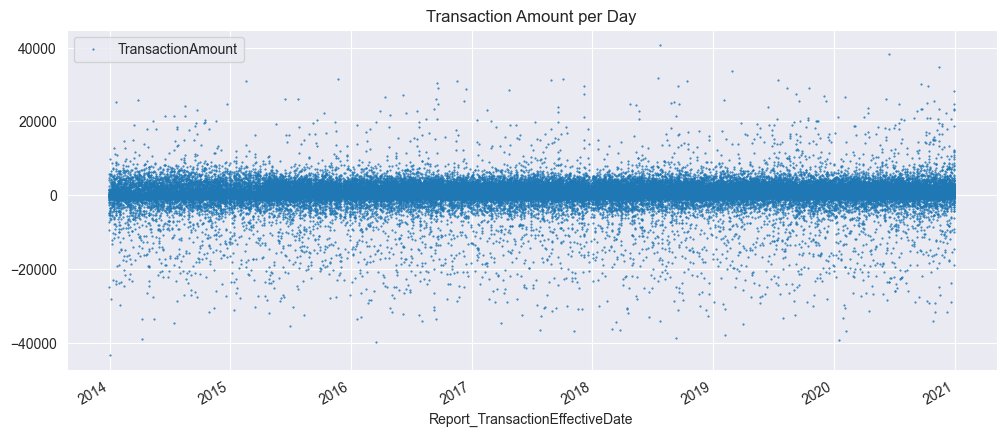

In [706]:
## Each Transaction Value
colour_pal = sns.color_palette()
df.plot(style='.', ms=1, figsize=(12, 5), color=colour_pal[0], title="Transaction Amount per Day" )
plt.show()

In [707]:
## Total Transaction value per day
df = df.groupby(["Report_TransactionEffectiveDate"])["TransactionAmount"].sum().asfreq('D').ffill().bfill().to_frame()
df

,TransactionAmount
Report_TransactionEffectiveDate,
2013-12-30,-1076.913729
2013-12-31,-41733.273687
2014-01-01,-3465.890925
2014-01-02,-45506.653405
2014-01-03,-18386.381900
...,...
2020-12-27,1763.692730
2020-12-28,1763.692730
2020-12-29,82156.304473


In [708]:
# Check for extreme outliers
q1, q3 = df['TransactionAmount'].quantile([0.25, 0.75])
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df['TransactionAmount'] < lower_bound) | (df['TransactionAmount'] > upper_bound)]
print("Outliers detected:", len(outliers))

Outliers detected: 98


In [709]:
df['TransactionAmount'] = np.clip(df['TransactionAmount'], lower_bound, upper_bound)

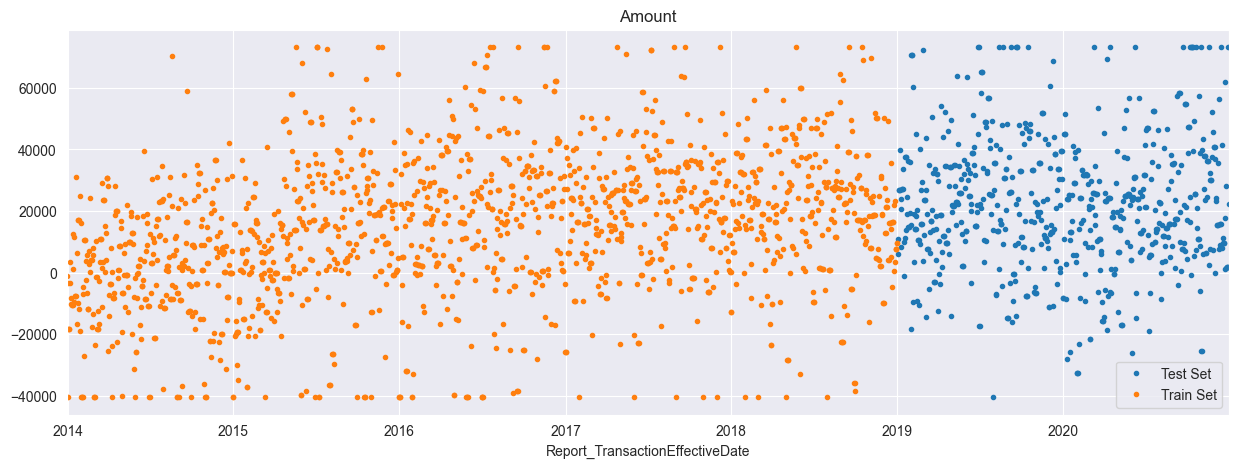

In [710]:
split_date = '1-Jan-2019'
data_train = df.loc[df.index <= split_date].copy()
data_test = df.loc[df.index > split_date].copy()

data_test.rename(columns={'TransactionAmount': 'Test Set'}).join(data_train.rename(columns={'TransactionAmount': 'Train Set'}), how='outer').plot(figsize=(15, 5), title="Amount", style='.')
plt.show()

In [711]:
shift = abs(data_train['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_train['TransactionAmount_shifted'] = data_train['TransactionAmount'] + shift  # Shift data
data_train['TransactionAmount_log'] = np.log1p(data_train['TransactionAmount_shifted'])  # Apply log

shift = abs(data_test['TransactionAmount'].min()) + 1  # Ensure all values are positive
data_test['TransactionAmount_shifted'] = data_test['TransactionAmount'] + shift  # Shift data
data_test['TransactionAmount_log'] = np.log1p(data_test['TransactionAmount_shifted'])  # Apply log

In [712]:
data_train_prophet = data_train.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_train_prophet

,ds,TransactionAmount,TransactionAmount_shifted,y
0,2013-12-30,-1076.913729,39341.466845,10.580060
1,2013-12-31,-40417.380574,1.000000,0.693147
2,2014-01-01,-3465.890925,36952.489649,10.517415
3,2014-01-02,-40417.380574,1.000000,0.693147
4,2014-01-03,-18386.381900,22031.998674,10.000297
...,...,...,...,...
1824,2018-12-28,7577.044740,47995.425314,10.778882
1825,2018-12-29,7577.044740,47995.425314,10.778882
1826,2018-12-30,7577.044740,47995.425314,10.778882
1827,2018-12-31,9481.245786,49899.626360,10.817789


In [713]:
%%time
model = Prophet(
    seasonality_prior_scale=1.0,
    yearly_seasonality=10,
    weekly_seasonality=5,
    daily_seasonality=False,
    changepoint_prior_scale=0.001,
    changepoint_range=0.9,
    seasonality_mode='multiplicative',
)

model.add_seasonality(name='monthly', period=30.5, fourier_order=12)
model.add_seasonality(name='weekly', period=7, fourier_order=18)
model.add_seasonality(name='yearly', period=365.25, fourier_order=25)

model.fit(data_train_prophet)

13:15:24 - cmdstanpy - INFO - Chain [1] start processing
13:15:25 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 375 ms
Wall time: 593 ms


In [714]:
data_test_prophet = data_test.reset_index().rename(columns={'Report_TransactionEffectiveDate': 'ds', 'TransactionAmount_log': 'y'})
data_test_predict = model.predict(data_test_prophet)
data_test_predict.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-01-02,10.737910,6.303151,10.722298,10.737910,10.737910,-0.147009,-0.147009,-0.147009,-0.205066,...,-0.004132,-0.004132,-0.004132,-0.053925,-0.053925,-0.053925,0.0,0.0,0.0,8.535926
1,2019-01-03,10.738101,7.166155,11.428355,10.738101,10.738101,-0.081674,-0.081674,-0.081674,-0.136491,...,-0.002727,-0.002727,-0.002727,-0.052090,-0.052090,-0.052090,0.0,0.0,0.0,9.272445
2,2019-01-04,10.738291,7.224481,11.617169,10.738291,10.738291,-0.062892,-0.062892,-0.062892,-0.126031,...,-0.013484,-0.013484,-0.013484,-0.049655,-0.049655,-0.049655,0.0,0.0,0.0,9.384937
3,2019-01-05,10.738482,7.750936,11.920467,10.738482,10.738482,-0.024373,-0.024373,-0.024373,-0.081901,...,-0.010819,-0.010819,-0.010819,-0.046708,-0.046708,-0.046708,0.0,0.0,0.0,9.858989
4,2019-01-06,10.738673,8.086154,12.069884,10.738673,10.738673,-0.000354,-0.000354,-0.000354,-0.050471,...,-0.006766,-0.006766,-0.006766,-0.043350,-0.043350,-0.043350,0.0,0.0,0.0,10.196681


In [715]:
data_test_predict['yhat_original'] = np.exp(data_test_predict['yhat']) - shift
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2019-01-02,10.737910,6.303151,10.722298,10.737910,10.737910,-0.147009,-0.147009,-0.147009,-0.205066,...,-0.004132,-0.004132,-0.053925,-0.053925,-0.053925,0.0,0.0,0.0,8.535926,-35323.831737
1,2019-01-03,10.738101,7.166155,11.428355,10.738101,10.738101,-0.081674,-0.081674,-0.081674,-0.136491,...,-0.002727,-0.002727,-0.052090,-0.052090,-0.052090,0.0,0.0,0.0,9.272445,-29777.643391
2,2019-01-04,10.738291,7.224481,11.617169,10.738291,10.738291,-0.062892,-0.062892,-0.062892,-0.126031,...,-0.013484,-0.013484,-0.049655,-0.049655,-0.049655,0.0,0.0,0.0,9.384937,-28510.723534
3,2019-01-05,10.738482,7.750936,11.920467,10.738482,10.738482,-0.024373,-0.024373,-0.024373,-0.081901,...,-0.010819,-0.010819,-0.046708,-0.046708,-0.046708,0.0,0.0,0.0,9.858989,-21288.841297
4,2019-01-06,10.738673,8.086154,12.069884,10.738673,10.738673,-0.000354,-0.000354,-0.000354,-0.050471,...,-0.006766,-0.006766,-0.043350,-0.043350,-0.043350,0.0,0.0,0.0,10.196681,-13604.351229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-12-27,10.876138,8.524184,12.732728,10.876138,10.876139,0.039618,0.039618,0.039618,-0.017939,...,-0.006766,-0.006766,-0.050792,-0.050792,-0.050792,0.0,0.0,0.0,10.681028,3103.867438
726,2020-12-28,10.876329,8.822280,13.224850,10.876328,10.876330,0.031472,0.031472,0.031472,0.011323,...,0.032990,0.032990,-0.053139,-0.053139,-0.053139,0.0,0.0,0.0,10.999480,19424.616854
727,2020-12-29,10.876520,8.469093,12.935979,10.876519,10.876520,0.032001,0.032001,0.032001,-0.017749,...,0.004939,0.004939,-0.054689,-0.054689,-0.054689,0.0,0.0,0.0,10.683475,3210.519433
728,2020-12-30,10.876710,8.112726,12.324799,10.876710,10.876711,-0.003706,-0.003706,-0.003706,-0.063274,...,-0.004132,-0.004132,-0.055436,-0.055436,-0.055436,0.0,0.0,0.0,10.188497,-13822.889796


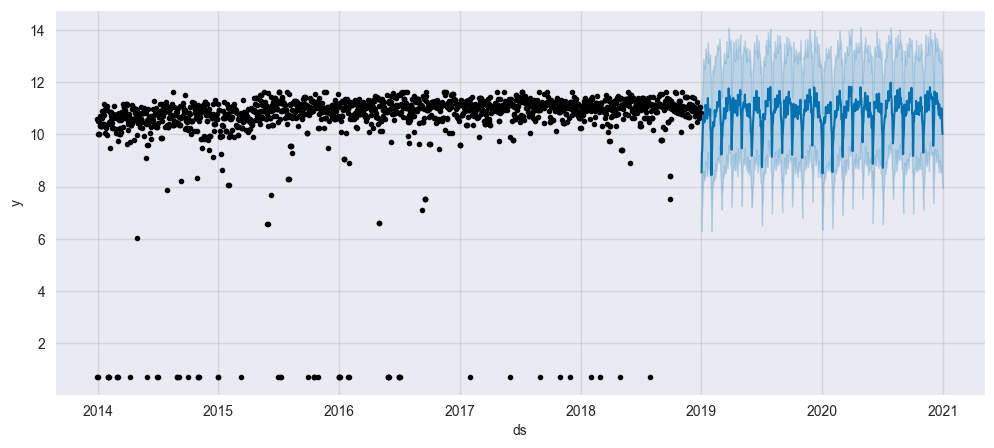

In [716]:
fig, ax = plt.subplots(figsize=(12, 5))
fig = model.plot(data_test_predict, ax=ax)
plt.show()

In [717]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,51504.365946,10.849441
2019-01-03,5997.282482,46415.663056,10.745414
2019-01-04,26741.238955,67159.619528,11.114842
2019-01-05,26741.238955,67159.619528,11.114842
2019-01-06,26741.238955,67159.619528,11.114842
...,...,...,...
2020-12-27,1763.692730,42182.073304,10.649774
2020-12-28,1763.692730,42182.073304,10.649774
2020-12-29,73263.818051,113682.198625,11.641171


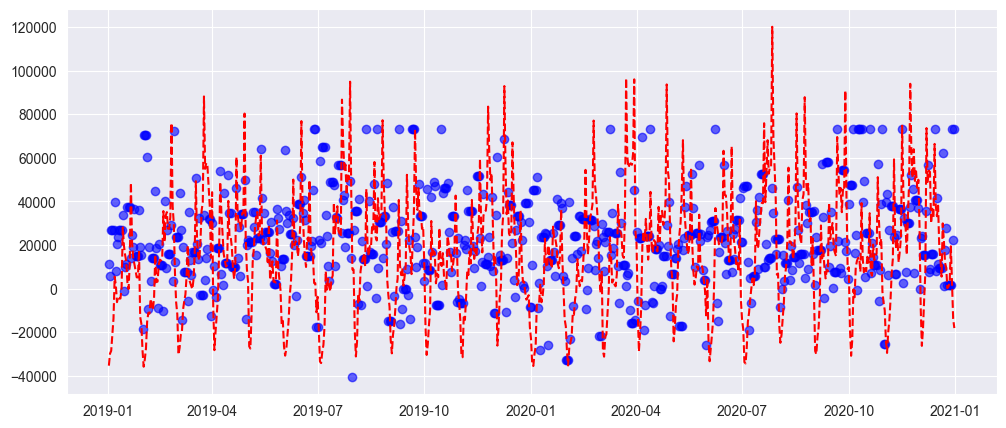

In [718]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.scatter(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(data_test.index, data_test_predict["yhat_original"], color='red', linestyle='dashed', label="Predicted")
plt.show()

In [719]:
data_test_predict

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2019-01-02,10.737910,6.303151,10.722298,10.737910,10.737910,-0.147009,-0.147009,-0.147009,-0.205066,...,-0.004132,-0.004132,-0.053925,-0.053925,-0.053925,0.0,0.0,0.0,8.535926,-35323.831737
1,2019-01-03,10.738101,7.166155,11.428355,10.738101,10.738101,-0.081674,-0.081674,-0.081674,-0.136491,...,-0.002727,-0.002727,-0.052090,-0.052090,-0.052090,0.0,0.0,0.0,9.272445,-29777.643391
2,2019-01-04,10.738291,7.224481,11.617169,10.738291,10.738291,-0.062892,-0.062892,-0.062892,-0.126031,...,-0.013484,-0.013484,-0.049655,-0.049655,-0.049655,0.0,0.0,0.0,9.384937,-28510.723534
3,2019-01-05,10.738482,7.750936,11.920467,10.738482,10.738482,-0.024373,-0.024373,-0.024373,-0.081901,...,-0.010819,-0.010819,-0.046708,-0.046708,-0.046708,0.0,0.0,0.0,9.858989,-21288.841297
4,2019-01-06,10.738673,8.086154,12.069884,10.738673,10.738673,-0.000354,-0.000354,-0.000354,-0.050471,...,-0.006766,-0.006766,-0.043350,-0.043350,-0.043350,0.0,0.0,0.0,10.196681,-13604.351229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2020-12-27,10.876138,8.524184,12.732728,10.876138,10.876139,0.039618,0.039618,0.039618,-0.017939,...,-0.006766,-0.006766,-0.050792,-0.050792,-0.050792,0.0,0.0,0.0,10.681028,3103.867438
726,2020-12-28,10.876329,8.822280,13.224850,10.876328,10.876330,0.031472,0.031472,0.031472,0.011323,...,0.032990,0.032990,-0.053139,-0.053139,-0.053139,0.0,0.0,0.0,10.999480,19424.616854
727,2020-12-29,10.876520,8.469093,12.935979,10.876519,10.876520,0.032001,0.032001,0.032001,-0.017749,...,0.004939,0.004939,-0.054689,-0.054689,-0.054689,0.0,0.0,0.0,10.683475,3210.519433
728,2020-12-30,10.876710,8.112726,12.324799,10.876710,10.876711,-0.003706,-0.003706,-0.003706,-0.063274,...,-0.004132,-0.004132,-0.055436,-0.055436,-0.055436,0.0,0.0,0.0,10.188497,-13822.889796


In [720]:
data_test

,TransactionAmount,TransactionAmount_shifted,TransactionAmount_log
Report_TransactionEffectiveDate,,,
2019-01-02,11085.985373,51504.365946,10.849441
2019-01-03,5997.282482,46415.663056,10.745414
2019-01-04,26741.238955,67159.619528,11.114842
2019-01-05,26741.238955,67159.619528,11.114842
2019-01-06,26741.238955,67159.619528,11.114842
...,...,...,...
2020-12-27,1763.692730,42182.073304,10.649774
2020-12-28,1763.692730,42182.073304,10.649774
2020-12-29,73263.818051,113682.198625,11.641171


In [721]:
np.sqrt(mean_squared_error(y_true=data_test["TransactionAmount"], y_pred = data_test_predict["yhat_original"]))

32013.921844869976

In [722]:
mean_absolute_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

24529.488983140385

In [723]:
mean_absolute_percentage_error(y_true=data_test['TransactionAmount'],
                   y_pred=data_test_predict['yhat_original'])

274.58696013796657

In [724]:
last_date_in_test = data_test.index[-1]
last_date_in_test

Timestamp('2020-12-31 00:00:00')

In [725]:
future = pd.date_range(start=last_date_in_test + pd.Timedelta(days=1), periods=90, freq='D')
future_df = pd.DataFrame({'ds': future}) 

forecast_future = model.predict(future_df)
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2021-01-01,10.877092,7.489109,11.928672,10.877092,10.877092,-0.037352,-0.037352,-0.037352,-0.105430,...,-0.013484,-0.013484,-0.013484,-0.054594,-0.054594,-0.054594,0.0,0.0,0.0,9.730321
1,2021-01-02,10.877282,6.702819,10.889311,10.877282,10.877282,-0.135244,-0.135244,-0.135244,-0.199151,...,-0.010819,-0.010819,-0.010819,-0.053088,-0.053088,-0.053088,0.0,0.0,0.0,8.711063
2,2021-01-03,10.877473,6.464989,10.820218,10.877473,10.877473,-0.147009,-0.147009,-0.147009,-0.204718,...,-0.006766,-0.006766,-0.006766,-0.050942,-0.050942,-0.050942,0.0,0.0,0.0,8.650661
3,2021-01-04,10.877664,7.597146,11.847179,10.877664,10.877664,-0.081674,-0.081674,-0.081674,-0.096924,...,0.032990,0.032990,0.032990,-0.048240,-0.048240,-0.048240,0.0,0.0,0.0,9.823357
4,2021-01-05,10.877854,7.736222,11.870607,10.877854,10.877854,-0.062892,-0.062892,-0.062892,-0.103027,...,0.004939,0.004939,0.004939,-0.045074,-0.045074,-0.045074,0.0,0.0,0.0,9.757146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,10.893298,9.451507,13.740748,10.893298,10.893298,0.032298,0.032298,0.032298,0.055560,...,-0.010819,-0.010819,-0.010819,0.034081,0.034081,0.034081,0.0,0.0,0.0,11.498524
86,2021-03-28,10.893488,9.415381,13.876930,10.893488,10.893488,0.040368,0.040368,0.040368,0.070430,...,-0.006766,-0.006766,-0.006766,0.036828,0.036828,0.036828,0.0,0.0,0.0,11.660712
87,2021-03-29,10.893679,9.826500,14.169671,10.893679,10.893679,0.034428,0.034428,0.034428,0.106372,...,0.032990,0.032990,0.032990,0.038954,0.038954,0.038954,0.0,0.0,0.0,12.052461
88,2021-03-30,10.893870,9.566922,13.970695,10.893870,10.893870,0.033227,0.033227,0.033227,0.078577,...,0.004939,0.004939,0.004939,0.040411,0.040411,0.040411,0.0,0.0,0.0,11.749874


In [726]:
forecast_future['yhat_original'] = np.exp(forecast_future['yhat']) - shift
forecast_future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat,yhat_original
0,2021-01-01,10.877092,7.489109,11.928672,10.877092,10.877092,-0.037352,-0.037352,-0.037352,-0.105430,...,-0.013484,-0.013484,-0.054594,-0.054594,-0.054594,0.0,0.0,0.0,9.730321,-23598.431420
1,2021-01-02,10.877282,6.702819,10.889311,10.877282,10.877282,-0.135244,-0.135244,-0.135244,-0.199151,...,-0.010819,-0.010819,-0.053088,-0.053088,-0.053088,0.0,0.0,0.0,8.711063,-34348.691725
2,2021-01-03,10.877473,6.464989,10.820218,10.877473,10.877473,-0.147009,-0.147009,-0.147009,-0.204718,...,-0.006766,-0.006766,-0.050942,-0.050942,-0.050942,0.0,0.0,0.0,8.650661,-34704.458937
3,2021-01-04,10.877664,7.597146,11.847179,10.877664,10.877664,-0.081674,-0.081674,-0.081674,-0.096924,...,0.032990,0.032990,-0.048240,-0.048240,-0.048240,0.0,0.0,0.0,9.823357,-21958.455667
4,2021-01-05,10.877854,7.736222,11.870607,10.877854,10.877854,-0.062892,-0.062892,-0.062892,-0.103027,...,0.004939,0.004939,-0.045074,-0.045074,-0.045074,0.0,0.0,0.0,9.757146,-23141.133160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2021-03-27,10.893298,9.451507,13.740748,10.893298,10.893298,0.032298,0.032298,0.032298,0.055560,...,-0.010819,-0.010819,0.034081,0.034081,0.034081,0.0,0.0,0.0,11.498524,58151.832833
86,2021-03-28,10.893488,9.415381,13.876930,10.893488,10.893488,0.040368,0.040368,0.040368,0.070430,...,-0.006766,-0.006766,0.036828,0.036828,0.036828,0.0,0.0,0.0,11.660712,75508.151440
87,2021-03-29,10.893679,9.826500,14.169671,10.893679,10.893679,0.034428,0.034428,0.034428,0.106372,...,0.032990,0.032990,0.038954,0.038954,0.038954,0.0,0.0,0.0,12.052461,131102.680910
88,2021-03-30,10.893870,9.566922,13.970695,10.893870,10.893870,0.033227,0.033227,0.033227,0.078577,...,0.004939,0.004939,0.040411,0.040411,0.040411,0.0,0.0,0.0,11.749874,86319.149410


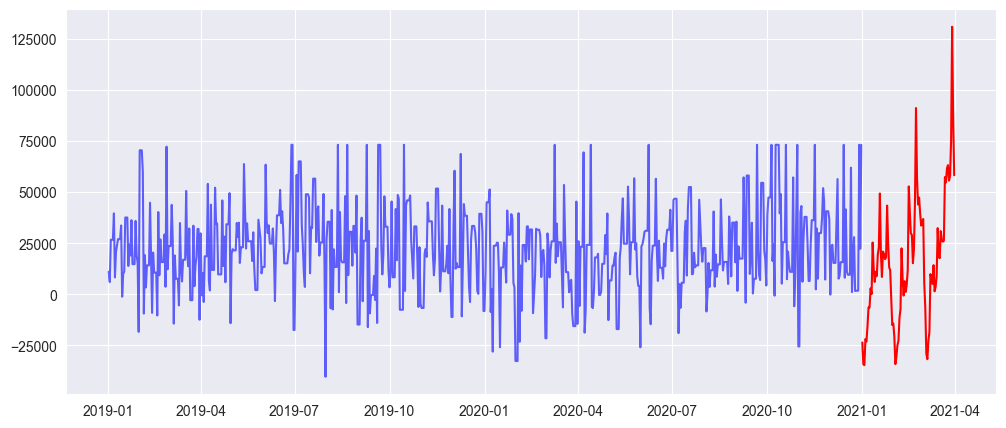

In [727]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(data_test.index, data_test["TransactionAmount"], color='blue', label="Actual Data", alpha=0.6)
ax.plot(forecast_future['ds'], forecast_future["yhat_original"], color='red', label="Predicted")
plt.show()

In [728]:
export_df = pd.DataFrame({
    'GroupName': 'Precision Analyst',
    'Date': forecast_future['ds'].dt.date,
    'TotalPredictedAmount': forecast_future['yhat_original']
})

# Round the predicted amounts to 2 decimal places
export_df['TotalPredictedAmount'] = export_df['TotalPredictedAmount'].round(2)

# Export to Excel
export_df.to_excel('forecast_results_prophet_2.xlsx', index=False)

# Display the first few rows of the exported data
print("Preview of exported data:")
print(export_df.head())

Preview of exported data:
           GroupName        Date  TotalPredictedAmount
0  Precision Analyst  2021-01-01             -23598.43
1  Precision Analyst  2021-01-02             -34348.69
2  Precision Analyst  2021-01-03             -34704.46
3  Precision Analyst  2021-01-04             -21958.46
4  Precision Analyst  2021-01-05             -23141.13
